In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import cifar10
from keras.losses import mse
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

Using TensorFlow backend.


In [0]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [0]:
def comp_vae_loss(inputs,outputs):
    # VAE loss = mse_loss
    reconstruction_loss = mse(inputs, outputs)
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)

    return vae_loss

In [0]:
# cifar10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

original_dim = 32 * 32 * 3
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
hid_layer1 = 768
hid_layer2 = 192
hid_layer3 = 48
hid_layer4 = 12
latent_dim = 2

batch_size = 128
epochs = 50

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
x_train.shape, x_test.shape

((50000, 3072), (10000, 3072))

In [0]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(hid_layer1, activation='relu')(inputs)
x = Dense(hid_layer2, activation = 'relu')(x)
x = Dense(hid_layer3, activation = 'relu')(x)
x = Dense(hid_layer4, activation = 'relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

W0718 06:21:02.187663 140350493734784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 06:21:02.246074 140350493734784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 06:21:02.249794 140350493734784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 06:21:02.332605 140350493734784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 3072)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 768)          2360064     encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 192)          147648      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 48)           9264        dense_2[0][0]                    
__________________________________________________________________________________________________
z_mean (De

In [0]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(hid_layer4, activation='relu')(latent_inputs)
x = Dense(hid_layer3, activation='relu')(x)
x = Dense(hid_layer2, activation='relu')(x)
x = Dense(hid_layer1, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 48)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 192)               9408      
_________________________________________________________________
dense_6 (Dense)              (None, 768)               148224    
_________________________________________________________________
dense_7 (Dense)              (None, 3072)              2362368   
Total params: 2,520,528
Trainable params: 2,520,528
Non-trainable params: 0
_________________________________________________________________


In [0]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [0]:
vae_loss = comp_vae_loss(inputs,outputs)
vae.add_loss(vae_loss)
vae.compile(optimizer='Adam')

vae.summary()
plot_model(vae, to_file='vae_mlp.png', show_shapes=True)

W0718 06:21:12.462645 140350493734784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 3072)              0         
_________________________________________________________________
encoder (Model)              [(None, 10), (None, 10),  2517956   
_________________________________________________________________
decoder (Model)              (None, 3072)              2520528   
Total params: 5,038,484
Trainable params: 5,038,484
Non-trainable params: 0
_________________________________________________________________


In [0]:
# train the autoencoder
history = vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
vae.save_weights('imageVAE.h5')

W0718 06:21:18.058242 140350493734784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 207us/step - loss: 138.4541 - val_loss: 124.5875
Epoch 2/50
50000/50000 [==============================] - 6s 116us/step - loss: 122.8446 - val_loss: 121.3332
Epoch 3/50
50000/50000 [==============================] - 6s 115us/step - loss: 112.6565 - val_loss: 109.9268
Epoch 4/50
50000/50000 [==============================] - 6s 115us/step - loss: 109.7943 - val_loss: 109.9270
Epoch 5/50
50000/50000 [==============================] - 6s 116us/step - loss: 106.4187 - val_loss: 104.5747
Epoch 6/50
50000/50000 [==============================] - 6s 116us/step - loss: 104.2321 - val_loss: 103.4120
Epoch 7/50
50000/50000 [==============================] - 6s 116us/step - loss: 103.3229 - val_loss: 102.6639
Epoch 8/50
50000/50000 [==============================] - 6s 117us/step - loss: 102.4250 - val_loss: 102.3186
Epoch 9/50
50000/50000 [==============================] - 6s 115us/st

dict_keys(['val_loss', 'loss'])


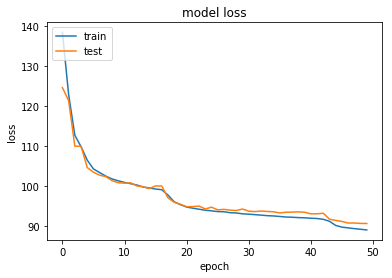

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(10000, 3072) (10000, 1) (10000, 10)
0.14936982 -0.13201192
0.13066591 -0.2501865
0.04889369 -0.3027563
0.04834646 -0.10358516
4.0234747 -4.065113
2.9116058 -2.892383
3.3455615 -4.5324564
3.85204 -3.2024786
3.875391 -5.9551435
4.1354384 -4.8796396
(1, 3072)


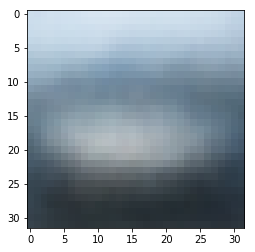

In [0]:
# Sanity Check
z_mean, z_log_var, z_val = encoder.predict(x_test, batch_size=batch_size)

print(x_test.shape, y_test.shape, z_mean.shape)
for i in range(2):
  print(np.max(z_mean[:,i]), np.min(z_mean[:,i]))

import random
# Method 1
i = 2
# z_sample = np.array([z_val[i,0], z_val[i,1], z_val[i,2], z_val[i,3], z_val[i,4], z_val[i,5], z_val[i,6], z_val[i,7], z_val[i,8], z_val[i,9]])
z_sample = np.array([z_val[i,0], z_val[i,1]])
z_sample = np.reshape(z_sample,(1,2))

# Method 2
# grid1 = np.linspace(np.min(z_mean[:,0]),np.max(z_mean[:,0]),10)
# grid2 = np.linspace(np.min(z_mean[:,0]),np.max(z_mean[:,0]),10)

# z_sample = np.array([[np.random]])


x_decoded = decoder.predict(z_sample)
print(x_decoded.shape)
plt.imshow(x_decoded.reshape(32,32,3))

In [0]:
np.min(z_log_var), np.max(z_log_var), z_val[1,:].shape, z_sample.shape

(-5.628181, 0.0616922, (10,), (10,))